In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from pathlib import Path
from sklearn import linear_model

print(pd.__version__)

1.5.3


In [2]:
PROJECT_PATH = Path('/work/rodrigues_2023')
TECAN_FILE = PROJECT_PATH / 'data' / 'plate_reader/MICkinetic1.xlsx'

In [3]:
# read input
df = pd.read_excel(TECAN_FILE, sheet_name='MagellanData')
# extract features
temp = df.iloc[0,1:]
time = [int(x[:-1]) for x in df.columns[1:]]
sample_name = df.iloc[1:,0].values[:-1]
od = df.iloc[1:-1,1:].values
# rebuild dataframe
df = pd.DataFrame(od, index=sample_name, columns=time).T
# find median blank
blank_median = np.median(df['Blank'].values)
# get non-blank samples
select_non_blank = df.columns[~df.columns.str.startswith('Blank')]
df = df[select_non_blank]
# subtract blank background
df = df - blank_median
# print final table
df

,PbEC1 0.4 1,PbEC1 0.4 2,PbEC1 0.4 3,PbEC2 0.4 1,PbEC2 0.4 2,PbEC2 0.4 3,PbEC3 0.4 1,PbEC3 0.4 2,PbEC3 0.4 3,PbEC4 0.4 1,...,PbEC1 0 3,PbEC2 0 1,PbEC2 0 2,PbEC2 0 3,PbEC3 0 1,PbEC3 0 2,PbEC3 0 3,PbEC4 0 1,PbEC4 0 2,PbEC4 0 3
0,0.0026,0.0012,0.0017,0.0015,0.0025,0.0011,0.0016,0.1022,0.1351,0.1408,...,0.0926,0.0959,0.1058,0.1109,0.1204,0.1176,0.1337,0.1472,0.1584,0.1238
300,0.0028,0.0018,0.0023,0.0023,0.0039,0.0019,0.0021,0.0008,0.0014,0.0008,...,0.0043,0.0039,0.0044,0.0063,0.0036,0.0033,0.0033,0.003,0.0036,0.0029
600,0.0028,0.0017,0.0022,0.0022,0.0041,0.0018,0.0019,0.0005,0.0012,0.0006,...,0.0024,0.0018,0.0027,0.0035,0.0063,0.0011,0.0006,0.0007,0.0012,0.0007
900,0.0029,0.0018,0.0022,0.0023,0.0037,0.0019,0.002,0.0008,0.0013,0.0008,...,0.0019,0.0012,0.0019,0.0032,0.0009,0.0005,0.0004,0.0002,0.0007,0.0002
1200,0.0029,0.0019,0.0024,0.0023,0.003,0.0019,0.0021,0.0009,0.0014,0.0007,...,0.0047,0.0042,0.0049,0.0058,0.0102,0.0035,0.0031,0.0031,0.0038,0.0031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85809,0.0082,0.008,0.0111,0.0081,0.0122,0.0095,0.0081,0.0082,0.0081,0.0075,...,1.0657,1.052,1.0722,1.0669,1.0571,1.0654,1.0491,1.0942,1.0726,1.0621
86109,0.0081,0.0081,0.0112,0.0082,0.0124,0.0097,0.0082,0.0084,0.0083,0.007,...,1.0686,1.0547,1.074,1.0688,1.0578,1.0665,1.0501,1.0959,1.0741,1.0638
86409,0.0084,0.0081,0.0112,0.0082,0.0125,0.01,0.0085,0.0087,0.0085,0.007,...,1.061,1.0464,1.0673,1.0635,1.0541,1.0618,1.0464,1.0932,1.071,1.0611
86709,0.0084,0.0081,0.0111,0.0084,0.0126,0.0102,0.0088,0.009,0.0088,0.0075,...,1.0691,1.0536,1.0738,1.0685,1.0586,1.0679,1.0512,1.097,1.0751,1.0648


In [4]:
dfl = df.melt(var_name='sample', ignore_index=False)
dfl['conc'] = dfl['sample'].apply(lambda x: float(x.split(' ')[1]))
dfl['replica'] = dfl['sample'].apply(lambda x: x.split(' ')[2])
dfl['sample'] = dfl['sample'].apply(lambda x: x.split(' ')[0])
dfl = dfl.reset_index(names=['time'])
dfl['time'] = dfl['time'].astype(float)/3600.
dfl['value'] = dfl['value'].astype(float)

In [5]:
# remove one outlier growth at 0.2
print(dfl.shape)
dfl = dfl[~((dfl['conc']==0.2) & (dfl['replica']=='1'))]
# get rid of first data points where we have an artificial peak
dfl = dfl[dfl['time']>0.1]
print(dfl.shape)

(24444, 5)
(23120, 5)


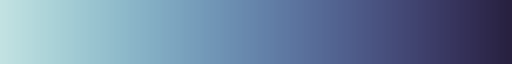

In [6]:
palette = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
palette

In [7]:
dfl

,time,sample,value,conc,replica
2,0.166667,PbEC1,0.0028,0.4,1
3,0.250000,PbEC1,0.0029,0.4,1
4,0.333333,PbEC1,0.0029,0.4,1
5,0.416667,PbEC1,0.0033,0.4,1
6,0.500000,PbEC1,0.0036,0.4,1
...,...,...,...,...,...
24439,23.835833,PbEC4,1.0621,0.0,3
24440,23.919167,PbEC4,1.0638,0.0,3
24441,24.002500,PbEC4,1.0611,0.0,3
24442,24.085833,PbEC4,1.0648,0.0,3


In [8]:
mpl.rcParams.update({'font.size': 6})

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5,3), dpi=300)
# sns.lineplot(x="time", y="value", hue="conc", data=dfl.query('conc in [0,0.025, 0.05, 0.1, 0.2, 0.4]'), palette='colorblind', ax=ax)
# ax.set_xticks(np.arange(0,25,6))
# ax.set_ylim([5e-3,1.2])
# ax.set_xlim([0,24])
# ax.set_yscale('log')
# ax.set_ylabel('OD600')
# ax.set_xlabel('time (h)')
# # Put a legend to the right of the current axis
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=6, title=r'$[CEF]$ $\mu g/mL$')

In [11]:
dfl_last5 =  dfl[dfl['time'] > dfl['time'].unique()[-5]]
od_final_mean = dfl_last5.groupby('conc')['value'].agg(np.mean)
od_final_std = dfl_last5.groupby('conc')['value'].agg(np.std)
od_final_mean

conc
0.0000    1.066104
0.0125    1.036308
0.0250    1.024517
0.0500    0.923567
0.1000    0.406827
0.2000    0.016622
0.4000    0.008879
Name: value, dtype: float64

Text(0.5, 0, 'Drug concentration')

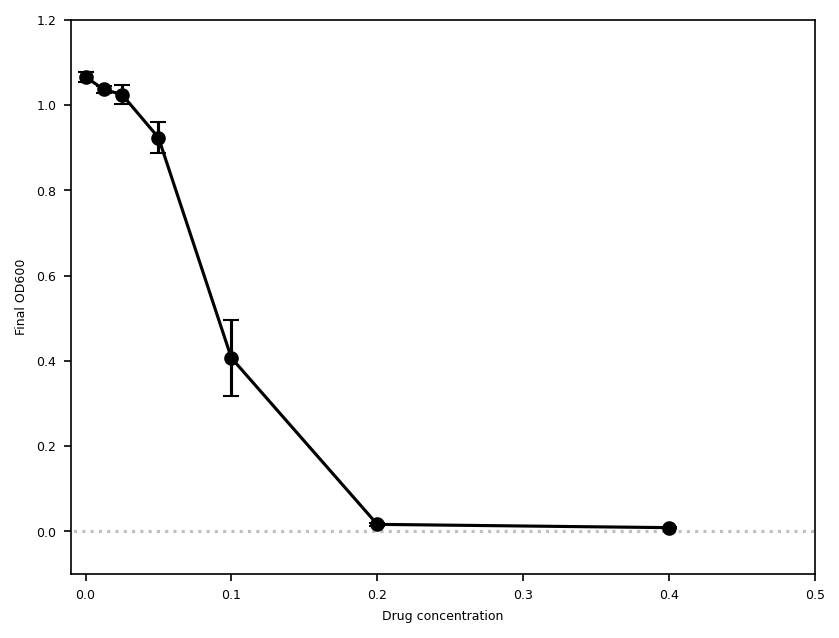

In [12]:
fig, ax = plt.subplots(1,1,dpi=150)
ax.errorbar(od_final_mean.index, od_final_mean, yerr=od_final_std, capsize=4, marker='o', color='k')
ax.plot([-1,0.5], [0,0], linestyle=':', color='gray', alpha=0.5)
ax.set_ylim([-0.1,1.2])
ax.set_xlim([-0.01,0.5])
ax.set_ylabel('Final OD600')
ax.set_xlabel('Drug concentration')

#### Plot full growth curves

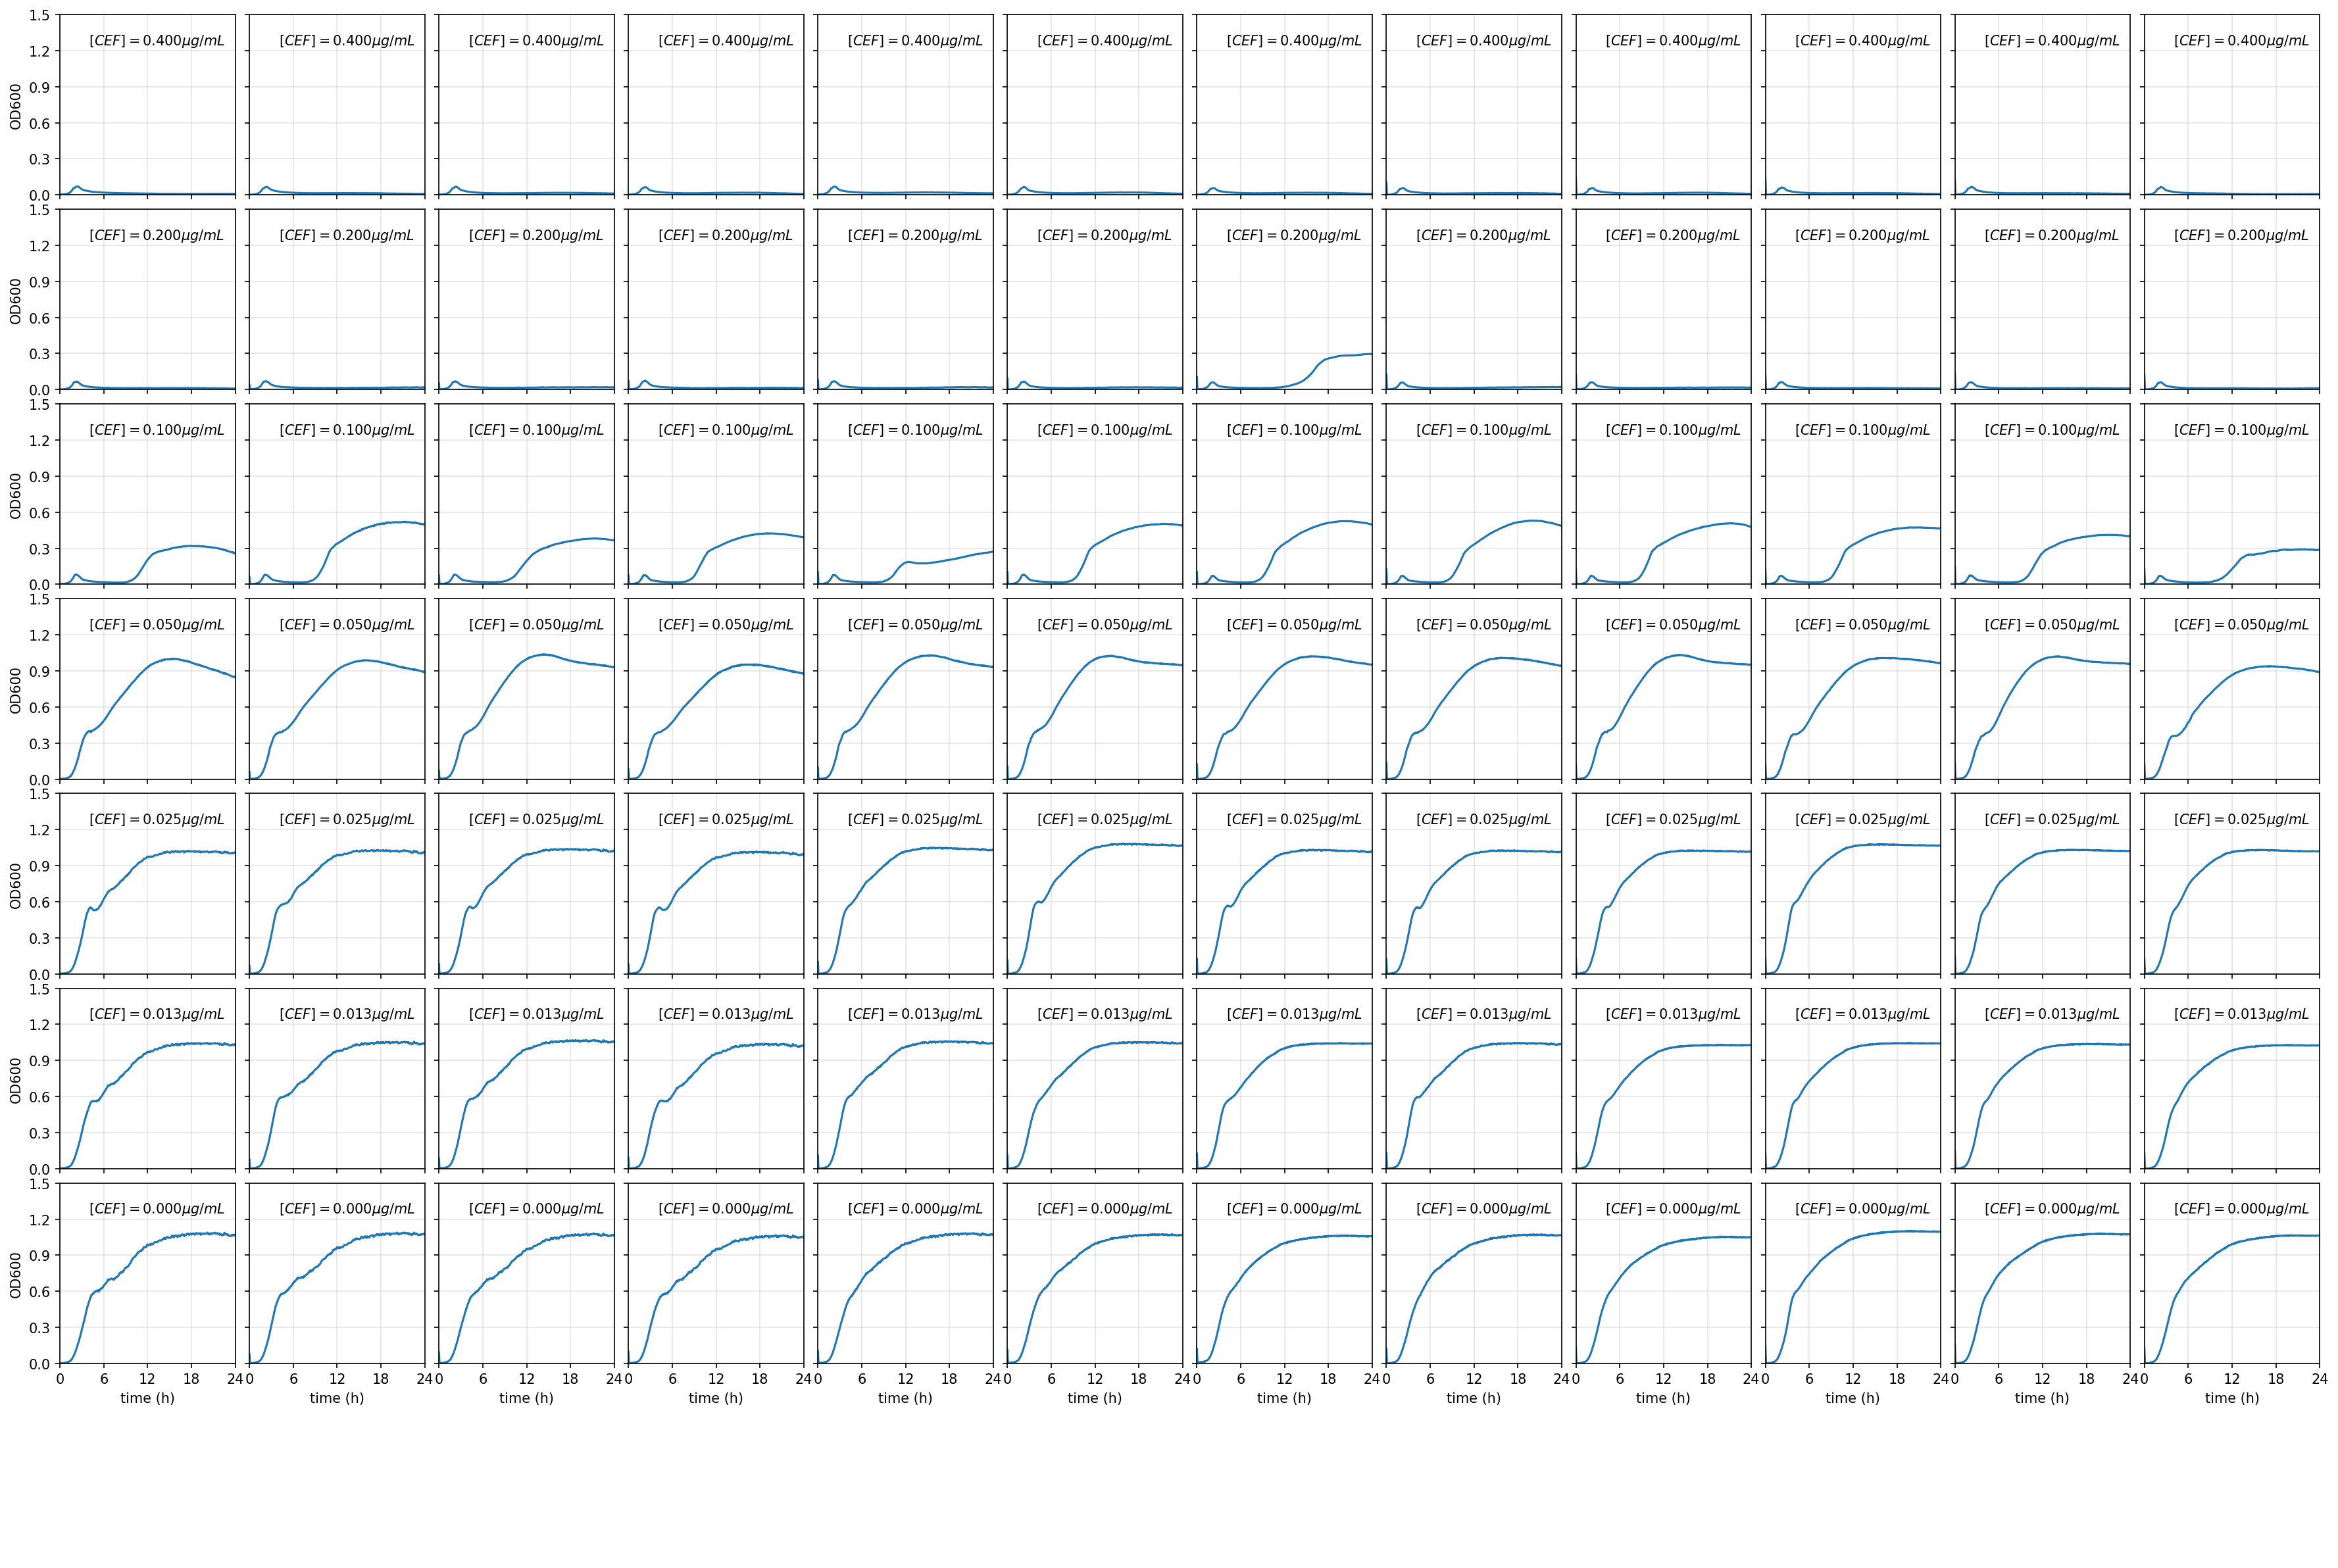

In [15]:
OD_max = 1.5
OD_tick_interval = 6
time_max = 24
time_tick_interval = 5
plt.style.use('default')
mpl.rcParams.update({'font.size': 10, 'axes.titlesize': 8})
fig, axes = plt.subplots(8,12, figsize=(24,16), dpi=150)
for axi, sample in enumerate(df.columns):
    ax = axes.flat[axi]
    ax.plot(df.index/3600, df.loc[:, sample])
    ax.set_yticks(np.linspace(0, OD_max, OD_tick_interval))
    ax.set_ylim([0, OD_max])
    ax.set_xticks(np.linspace(0, time_max, time_tick_interval))
    ax.set_xlim([0, time_max])
    ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.0f'))

    ax.text(4, 1.25, r'$[CEF]=%.3f  \mu g/mL$'%(float(sample.split(' ')[1])))
    #ax.set_title(sample)
    if axi%12==0:
        ax.set_ylabel('OD600')
    else:
        ax.set_yticklabels([])
    if axi//12==6:
        ax.set_xlabel('time (h)')
    else:
        ax.set_xticklabels([])
    ax.grid('.', alpha=0.33)

for axi in range(len(df.columns),96):
    axes.flat[axi].set_axis_off()

plt.tight_layout()
plt.subplots_adjust(wspace=0.08, hspace=0.08)

plt.savefig(PROJECT_PATH / 'figures/Adam/Full growth curves.png',dpi=600)

#### Growth curve fits

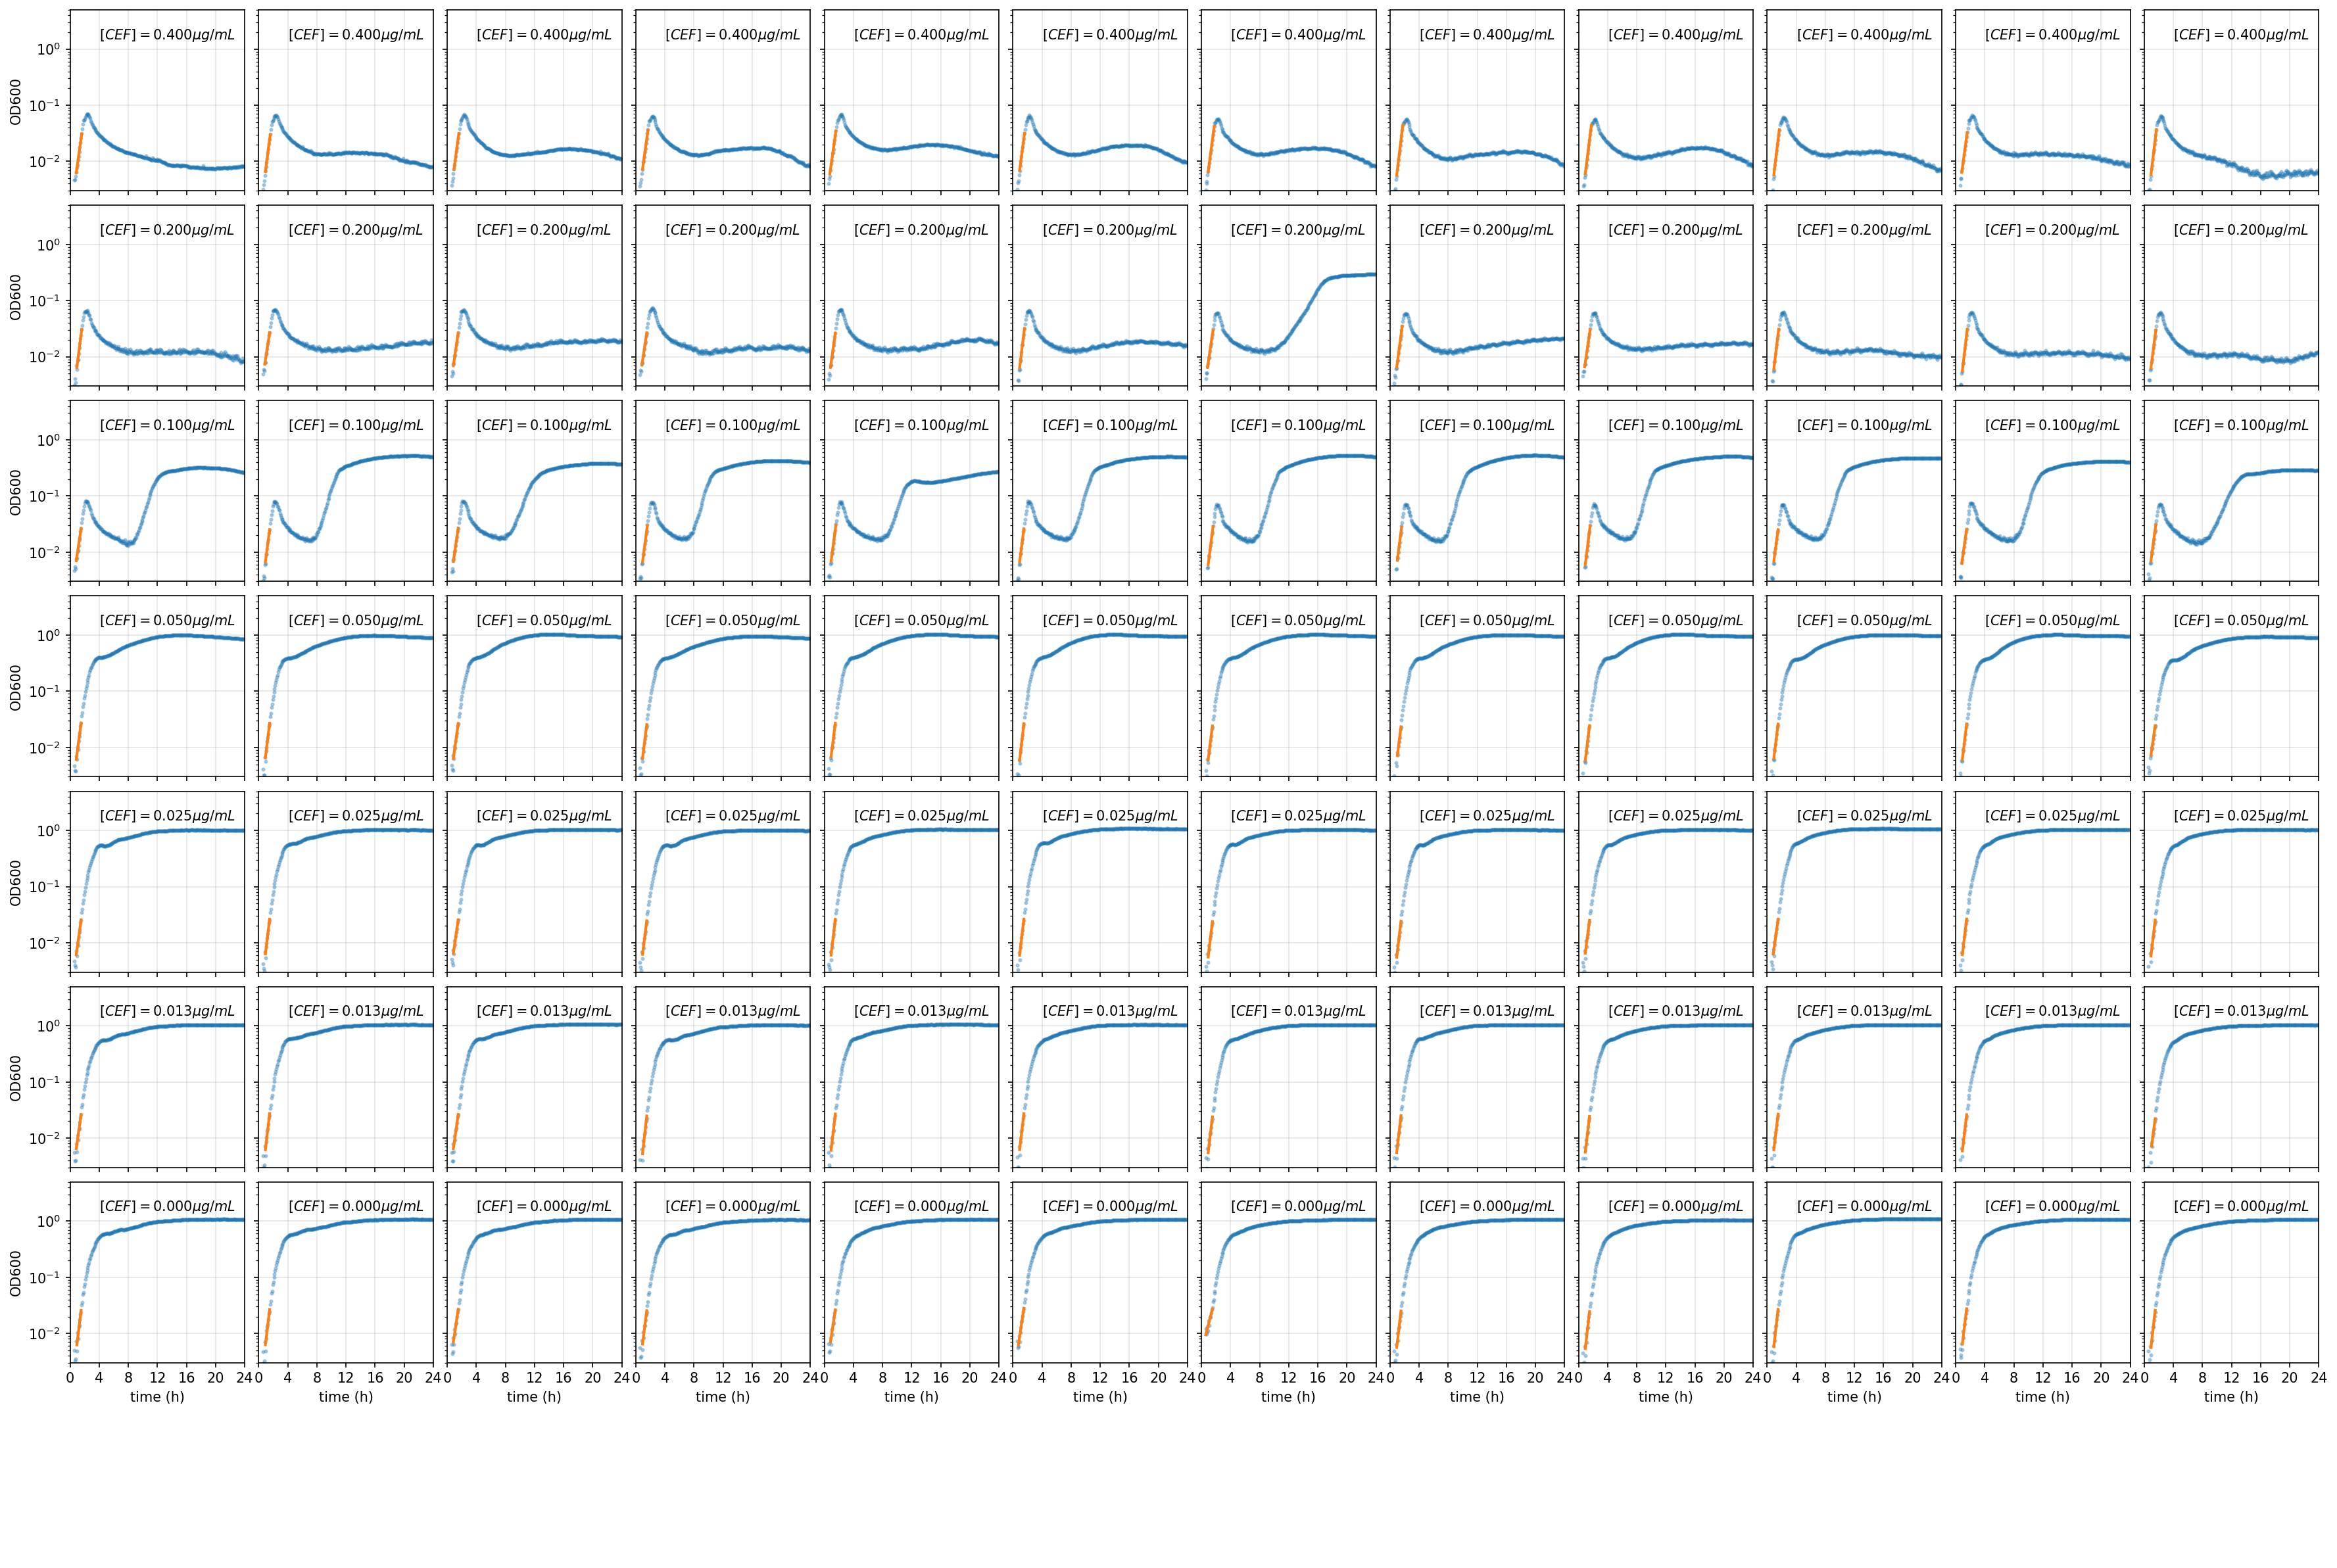

In [17]:
# specify plotting range
OD_max = 5
OD_tick_interval = 6
time_max = 24
time_tick_interval = 7
# specify relevant experiment time in hours
roi_range = [0.5, 24]
# specify relevant growth phase in OD
fit_min_od = 0.01
fit_max_od = 0.05
# collect results here
results = []

plt.style.use('default')
mpl.rcParams.update({'font.size': 10, 'axes.labelsize':10})
fig, axes = plt.subplots(8,12, figsize=(24,16), dpi=150)
for axi, sample in enumerate(df.columns):
    ax = axes.flat[axi]
    # get OD values
    od = df.loc[:, sample].astype(float).values
    time = np.array(list(df.index.astype(float)))
    # convert zeroes to inifitesmall floats for log function
    od[od<1e-5] = 1e-5
    # slice the interested time window
    roi_start = np.min(np.where(time>(roi_range[0]*3600))[0])
    try:
        roi_end = np.min(np.where(time>(roi_range[1]*3600))[0])
    except ValueError:
        roi_end = len(time)-1
    od = od[roi_start:roi_end]
    time = time[roi_start:roi_end]/3600.
    smooth_od = np.convolve(od,np.ones(6)/6,mode='valid')
    fit_start = np.min(np.where(smooth_od>fit_min_od)[0])
    fit_end = np.min(np.where(smooth_od>fit_max_od)[0])
    fit_y = od[fit_start:fit_end]
    fit_x = time[fit_start:fit_end]
    model_ransac=linear_model.RANSACRegressor(linear_model.LinearRegression())
    model_linear_reg = linear_model.LinearRegression()
    # print(fit_x)
    # print(np.log2(fit_y))
    model_linear_reg.fit(fit_x[:,np.newaxis], np.log(fit_y))
    fit_predict = np.power(np.e,model_linear_reg.predict(fit_x[:,np.newaxis]))
    doubl_est = np.log(2)/model_linear_reg.coef_[0]
    ax.plot(time, od, 'o', ms=2, alpha=0.33)
    ax.plot(fit_x, fit_predict, lw=2)
    ax.set_yticks(np.linspace(1e-4, OD_max, OD_tick_interval))
    ax.set_ylim([3e-3, OD_max])
    ax.set_xticks(np.linspace(0, time_max, time_tick_interval))
    ax.set_xlim([0, time_max])
    ax.set_yscale('log')
    #ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.1f'))
    ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.0f'))
    #ax.set_title(sample)
    ax.grid('.', alpha=0.33)
    #ax.text(0.5, 0.1, r"$T_{d} = %.3f$"%(doubl_est/3600.), fontsize=6, transform = ax.transAxes)
    #ax.text(0.5, 0.1, r"$r = %.2f$ $h^{-1}$"%(model_linear_reg.coef_[0]), fontsize=10, transform = ax.transAxes)
    ax.text(4, 1.5, r'$[CEF]=%.3f  \mu g/mL$'%(float(sample.split(' ')[1])))
    #ax.set_title(sample)
    if axi%12==0:
        ax.set_ylabel('OD600')
    else:
        ax.set_yticklabels([])
    if axi//12==6:
        ax.set_xlabel('time (h)')
    else:
        ax.set_xticklabels([])
    ax.grid('.', alpha=0.33)

    # record results
    results.append({'sample': sample,
                    'growth_rate': model_linear_reg.coef_[0],
                    'doubling_time': doubl_est,
                    'OD_final': smooth_od[-1],
                    'AUC': np.trapz(y=smooth_od, x=time[:len(smooth_od)])})


for axi in range(len(df.columns),96):
    axes.flat[axi].set_axis_off()

plt.tight_layout()
plt.subplots_adjust(wspace=0.08, hspace=0.08)
plt.savefig(PROJECT_PATH / 'figures/Adam/Growth curve fits.png', dpi=600)

In [18]:
results_df = pd.DataFrame(results)
results_df.to_csv(PROJECT_PATH / 'figures/Adam/Growth curve fit results.txt', sep='\t', index=False)

In [19]:
results_df

,sample,growth_rate,doubling_time,OD_final,AUC
0,PbEC1 0.4 1,2.121474,0.326729,0.008133,0.351056
1,PbEC1 0.4 2,2.269470,0.305422,0.008017,0.389440
2,PbEC1 0.4 3,2.213509,0.313144,0.011317,0.418555
3,PbEC2 0.4 1,2.142906,0.323461,0.008383,0.412024
4,PbEC2 0.4 2,2.104452,0.329372,0.012467,0.471529
...,...,...,...,...,...
79,PbEC3 0 2,2.570328,0.269673,1.066183,19.427707
80,PbEC3 0 3,2.605495,0.266033,1.049683,19.239255
81,PbEC4 0 1,2.612571,0.265312,1.095567,20.245489
82,PbEC4 0 2,2.470569,0.280562,1.073600,19.749946


In [20]:
dfr = results_df
dfr['conc'] = dfr['sample'].apply(lambda x: float(x.split(' ')[1]))
dfr['replica'] = dfr['sample'].apply(lambda x: x.split(' ')[2])
dfr['sample'] = dfr['sample'].apply(lambda x: x.split(' ')[0])
dfr['AUC'] = dfr['AUC'] / np.median(dfr.loc[dfr['conc']==0,'AUC'])
dfr

,sample,growth_rate,doubling_time,OD_final,AUC,conc,replica
0,PbEC1,2.121474,0.326729,0.008133,0.018144,0.4,1
1,PbEC1,2.269470,0.305422,0.008017,0.020128,0.4,2
2,PbEC1,2.213509,0.313144,0.011317,0.021633,0.4,3
3,PbEC2,2.142906,0.323461,0.008383,0.021295,0.4,1
4,PbEC2,2.104452,0.329372,0.012467,0.024371,0.4,2
...,...,...,...,...,...,...,...
79,PbEC3,2.570328,0.269673,1.066183,1.004103,0.0,2
80,PbEC3,2.605495,0.266033,1.049683,0.994363,0.0,3
81,PbEC4,2.612571,0.265312,1.095567,1.046369,0.0,1
82,PbEC4,2.470569,0.280562,1.073600,1.020758,0.0,2


In [21]:
gr_mean = dfr.groupby('conc')['growth_rate'].agg(np.mean)
gr_std = dfr.groupby('conc')['growth_rate'].agg(np.std)
auc_mean = dfr.groupby('conc')['AUC'].agg(np.mean)
auc_std = dfr.groupby('conc')['AUC'].agg(np.std)
gr_mean

conc
0.0000    2.271521
0.0125    2.449051
0.0250    2.381190
0.0500    2.356985
0.1000    2.224866
0.2000    2.204645
0.4000    2.274447
Name: growth_rate, dtype: float64

Text(0.5, 0, 'Drug concentration')

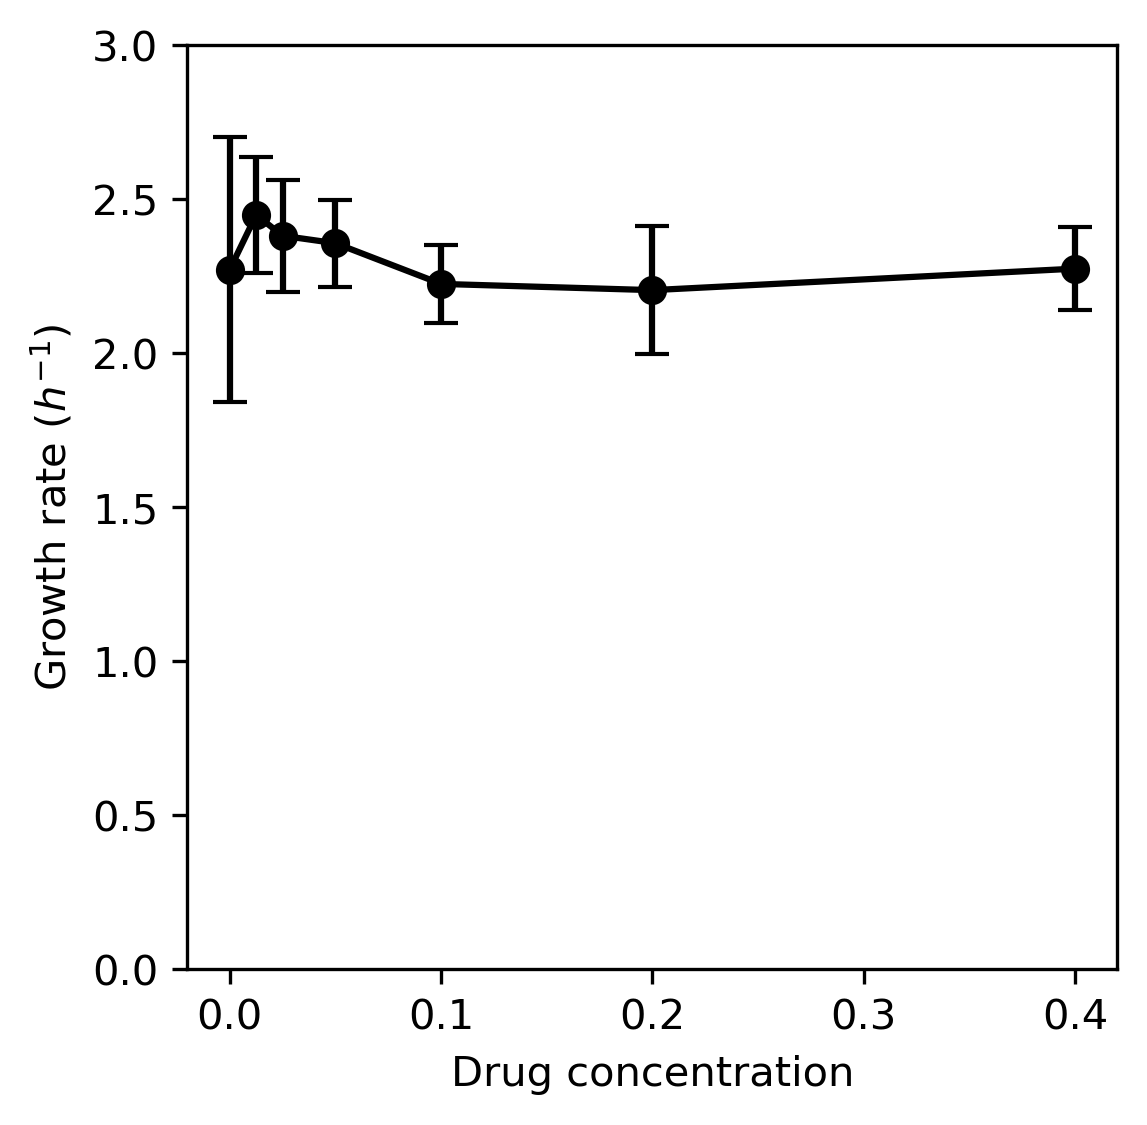

In [22]:
fig, ax = plt.subplots(1,1,figsize=(4,4),dpi=300)
ax.errorbar(gr_mean.index, gr_mean, yerr=(gr_std), capsize=4, marker='o', color='k')
plt.ylim([0,3])
ax.set_ylabel(r'Growth rate $(h^{-1})$')
ax.set_xlabel('Drug concentration')

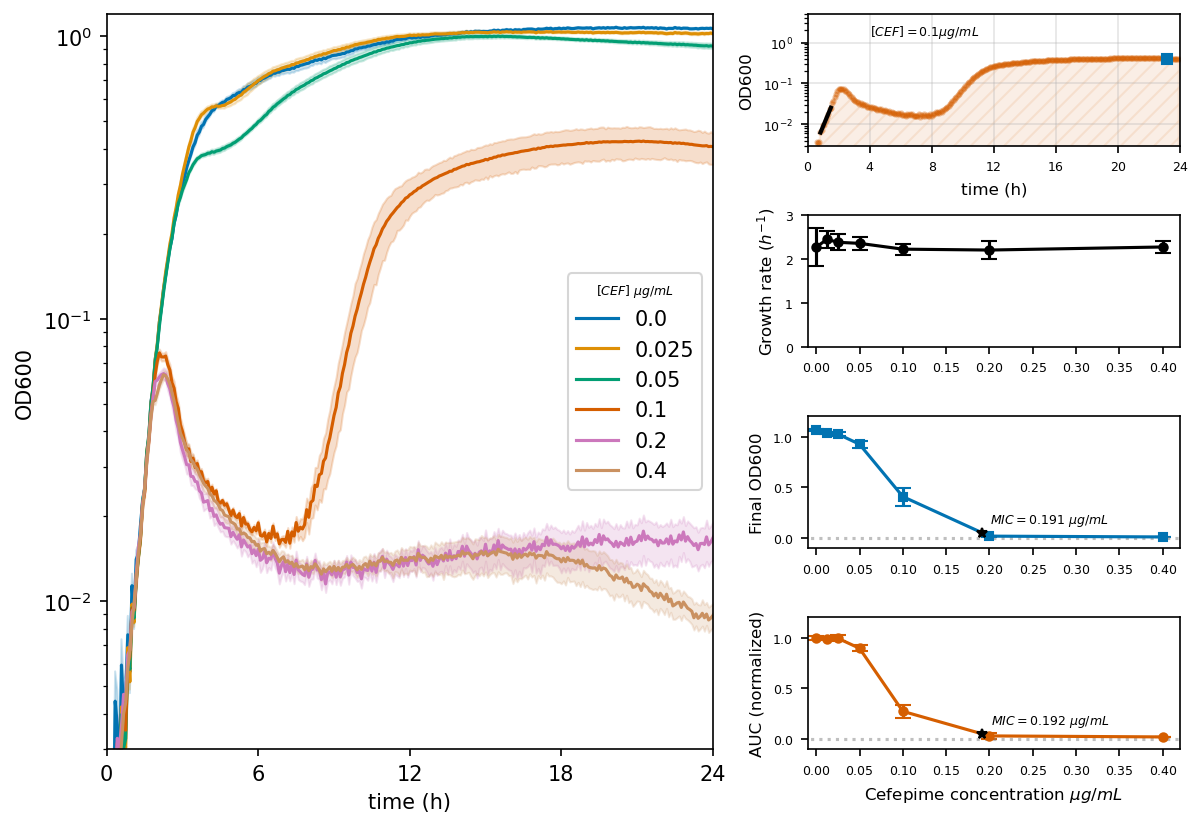

In [25]:
palette = sns.color_palette("colorblind")
mpl.rcParams.update({'axes.labelsize':8, 'font.size': 6, 'legend.fontsize':8})
fig = plt.figure(figsize=(8, 5.5),dpi=150)
gs = GridSpec(4, 5, figure=fig)
ax_left = fig.add_subplot(gs[0:4, 0:3])
# Figure 1A. Consensus full growth curves at each drug concentration
sns.lineplot(x="time", y="value", hue="conc", data=dfl.query('conc in [0,0.025, 0.05, 0.1, 0.2, 0.4]'), palette='colorblind', ax=ax_left)
ax_left.set_xticks(np.arange(0,25,6))
ax_left.set_ylim([3e-3,1.2])
ax_left.set_xlim([0,24])
ax_left.set_yscale('log')
ax_left.set_ylabel('OD600', fontsize=10)
ax_left.set_xlabel('time (h)', fontsize=10)
ax_left.legend(loc='center right', fontsize=10, title=r'$[CEF]$ $\mu g/mL$')
ax_left.tick_params(axis='both', which='major', labelsize=10)
## Figure 1B. Sample curve
sample = 'PbEC4 0.1 2'
ax_b = fig.add_subplot(gs[0,3:5])
# get OD values
od = df.loc[:, sample].astype(float).values
time = np.array(list(df.index.astype(float)))
# convert zeroes to inifitesmall floats for log function
od[od<1e-5] = 1e-5
# slice the interested time window
roi_start = np.min(np.where(time>(roi_range[0]*3600))[0])
try:
    roi_end = np.min(np.where(time>(roi_range[1]*3600))[0])
except ValueError:
    roi_end = len(time)-1
od = od[roi_start:roi_end]
time = time[roi_start:roi_end]/3600.
smooth_od = np.convolve(od,np.ones(6)/6,mode='valid')
fit_start = np.min(np.where(smooth_od>fit_min_od)[0])
fit_end = np.min(np.where(smooth_od>fit_max_od)[0])
fit_y = od[fit_start:fit_end]
fit_x = time[fit_start:fit_end]
model_linear_reg = linear_model.LinearRegression()
model_linear_reg.fit(fit_x[:,np.newaxis], np.log(fit_y))
fit_predict = np.power(np.e,model_linear_reg.predict(fit_x[:,np.newaxis]))
doubl_est = np.log(2)/model_linear_reg.coef_[0]
# plot OD measurements
ax_b.plot(time, od, 'o', color=palette[3], ms=2, alpha=0.33)
# plot fit
ax_b.plot(fit_x, fit_predict, color='black', lw=2)
# plot OD final
ax_b.plot(time[-10],od[-10], color=palette[0], marker='s', ms=5)
# plot AUC
ax_b.fill_between(time, od, color=palette[3], hatch='///', alpha=0.1)
ax_b.set_yticks(np.linspace(1e-4, OD_max, OD_tick_interval))
ax_b.set_ylim([3e-3, OD_max])
ax_b.set_xticks(np.linspace(0, time_max, time_tick_interval))
ax_b.set_xlim([0, time_max])
ax_b.set_yscale('log')
ax_b.set_ylabel('OD600')
ax_b.set_xlabel('time (h)')
ax_b.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.0f'))
ax_b.grid('.', alpha=0.33)
ax_b.text(4, 1.5, r'$[CEF]=%.1f  \mu g/mL$'%(float(sample.split(' ')[1])))
## Figure 1C. Growth rates
ax_c = fig.add_subplot(gs[1,3:5])
ax_c.errorbar(gr_mean.index, gr_mean, yerr=(gr_std), capsize=4, marker='o', markersize=4, color='k')
ax_c.set_xlim([-0.01,0.42])
ax_c.set_ylim([0,3])
ax_c.set_ylabel(r'Growth rate $(h^{-1})$')
## Figure 1D. Final OD
ax_d = fig.add_subplot(gs[2,3:5])
ax_d.errorbar(od_final_mean.index, od_final_mean, yerr=od_final_std, capsize=4, marker='s', markersize=4, color=palette[0])
ax_d.plot([-1,0.5], [0,0], linestyle=':', color='gray', alpha=0.5)
predicted_MIC_by_fod = np.interp([0.05], od_final_mean.values[::-1], od_final_mean.index[::-1])
ax_d.plot(predicted_MIC_by_fod, [0.05], '*', markersize=5, color='black', zorder=20)
ax_d.text(predicted_MIC_by_fod[0]*1.05, 0.05*3, r'$MIC=%.3f$ $\mu g/mL$'%predicted_MIC_by_fod[0])
#ax_d.set_xticklabels([])
ax_d.set_ylim([-0.1,1.2])
ax_d.set_xlim([-0.01,0.42])
ax_d.set_ylabel('Final OD600')
# Figure 1E. AUC
ax_e = fig.add_subplot(gs[3,3:5])
ax_e.errorbar(auc_mean.index, auc_mean, yerr=auc_std, capsize=4, marker='o', markersize=4, color=palette[3])
ax_e.plot([-1,0.5], [0,0], linestyle=':', color='gray', alpha=0.5)
predicted_MIC_by_auc = np.interp([0.05], auc_mean.values[::-1], auc_mean.index[::-1])
ax_e.plot(predicted_MIC_by_auc, [0.05],  '*', markersize=5, color='black', zorder=20)
ax_e.text(predicted_MIC_by_auc[0]*1.05, 0.05*3, r'$MIC=%.3f$ $\mu g/mL$'%predicted_MIC_by_auc[0])
ax_e.set_ylim([-0.1,1.2])
ax_e.set_xlim([-0.01,0.42])
ax_e.set_ylabel('AUC (normalized)')
ax_e.set_xlabel(r'Cefepime concentration $\mu g/mL$')

plt.tight_layout()
plt.savefig(PROJECT_PATH / 'figures/Adam/Publication Figure.png', dpi=600)

In [24]:
predicted_MIC_by_fod = np.interp([0.05], od_final_mean.values[::-1], od_final_mean.index[::-1])[0]
predicted_MIC_by_auc = np.interp([0.05], auc_mean.values[::-1], auc_mean.index[::-1])[0]
print(predicted_MIC_by_fod, predicted_MIC_by_auc)

0.1914460073091883 0.19174158991679338
